<a href="https://colab.research.google.com/github/eli6/colab_test/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder 🤖

Walkthrough of Chapter 3 from the book "Generative Deep Learning" by David Foster. Most examples are taken directly from the book or the associated GitHub repo with the notebooks, but some changes have been made in order to experiment.

In [18]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt



In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


# preprocessing of images
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)


4422102/4422102 [==============================] - 1s 0us/step


In [4]:
# creating the encoder
encoder_input = layers.Input(shape=(32, 32, 1), name='encoder_input')
x = layers.Conv2D(32, (3,3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)


In [5]:
# creating the decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation = 'relu', padding="same")(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)

In [6]:
# combining the encoder and decoder to create the autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# training the autoencoder
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test),
)


Epoch 1/5
600/600 [==============================] - 14s 10ms/step - loss: 0.2960 - val_loss: 0.2627
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2575 - val_loss: 0.2564
Epoch 3/5
600/600 [==============================] - 5s 9ms/step - loss: 0.2535 - val_loss: 0.2537
Epoch 4/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2515 - val_loss: 0.2522
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2503 - val_loss: 0.2509


In [8]:
autoencoder.save('autoencoder.keras')
encoder.save('encoder.keras')
decoder.save('decoder.keras')

157/157 [==============================] - 0s 2ms/step


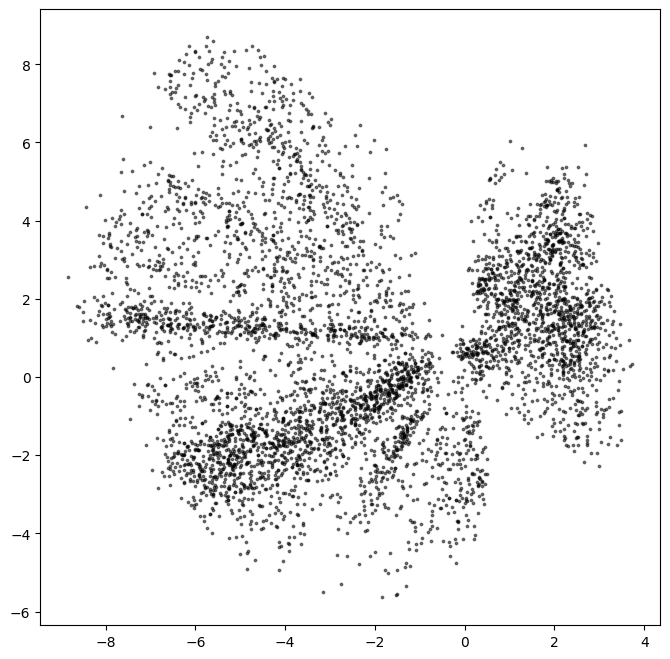

In [13]:
example_images = x_test[:5000]

embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [14]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18, 2))
reconstructions = decoder.predict(sample)

1/1 [==============================] - 1s 547ms/step


In [21]:
# Code copied from the author's own notebook utils: https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/utils.py
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("on")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

Example real clothing items


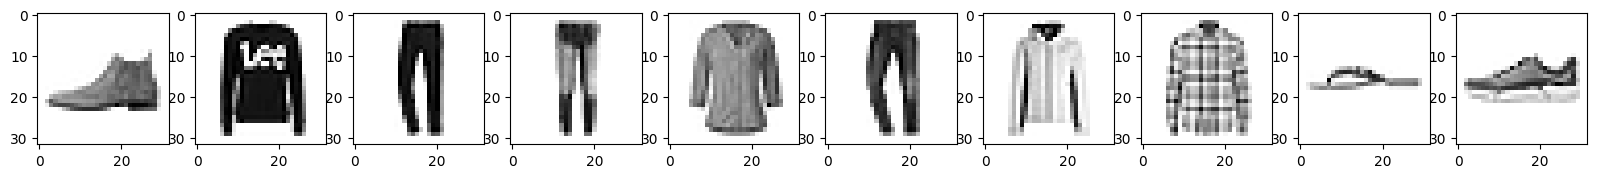

Reconstructions


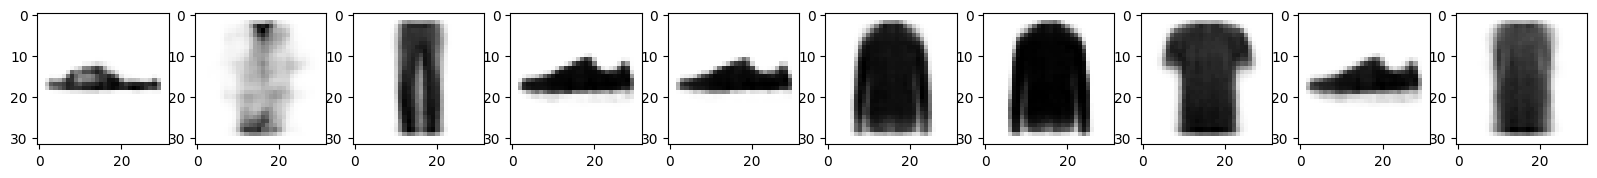

In [22]:
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)